The structure of our tutorial will go as follows (it will follow pretty closely the tutorial from Ben sorcher which goes over his paper: https://github.com/ganguli-lab/grid-pattern-formation/blob/master/inspect_model.ipynb)

- https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002553 for rat foraging 
- Show real grid cell + place cell ratemaps
- Plot simulated place cell ratemaps
- Plot simulated trajectories
- Get time-series of place cells
- Intro to RNNs
- Hardcoded RNNs that make grid cells (ila fiete paper 2009 https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1000291&type=printable): (matlab code here: https://www.dropbox.com/sh/ird9hnh8xbh76m8/AADIvXSqkUsWsVrUAoJFOU23a?e=1&dl=0, eqns from “IDEALIZED PATH INTEGRATOR MODELS” section in https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf )
- Train a RNN to predict place cells (ref ben sorscher paper)(Do with when only inputting place cell for time-step 0 and none thereafter)
- Plot RNN neuron ratemaps
- Train with/without Relu and see difference in ratemaps. Ideally would have hexagonal grids in relu case (like ben sorcher sees)
- Low dimensional population analysis to see torus (Fig 4 of https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf) + relate to low dimensional of real grid cells (figure from https://www.nature.com/articles/s41586-021-04268-7) as well as low dim analysis of idealised path integration model
- Eigen vals of RNN conectivity matrix and relate to idealised attractor connectivity matrices ( (Fig 5 of https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import os
import pickle
import pandas as pd

# Testing simulated trajectories

In [2]:
from neuralplayground.agents import TrajectoryGenerator
from neuralplayground.vendored import PlaceCells, RNN

In [3]:
# Using same parameters as the original paper
room_width = 2.2
room_depth = 2.2
sequence_length = 20
batch_size = 256
n_place_cells = 512
n_grid_cells = 512
learning_rate = 5e-4
training_steps = 100000
activation = "relu"
weight_decay = 1e-4 #1e-4
place_cell_rf = 0.12
surround_scale = 2.0
periodic = False
difference_of_gaussians = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
place_cells = PlaceCells(Np=n_place_cells, 
                         place_cell_rf=place_cell_rf,
                         surround_scale=surround_scale, 
                         room_width=room_width, 
                         room_depth=room_depth, 
                         periodic=periodic, 
                         DoG=difference_of_gaussians,
                         device=device)

In [5]:
# TODO: We should add offline trajectory generation to the package
generator = TrajectoryGenerator(sequence_length, batch_size, room_width, room_depth, device, place_cells=place_cells)
traj = generator.generate_trajectory(room_width, room_depth, batch_size)

In [6]:
rnn = RNN(Ng=n_grid_cells,
          Np=n_place_cells,
          sequence_length=sequence_length,
          weight_decay=weight_decay,
          place_cells=place_cells,
          activation=activation)
rnn.to(device)

RNN(
  (encoder): Linear(in_features=512, out_features=512, bias=False)
  (RNN): RNN(2, 512, bias=False)
  (decoder): Linear(in_features=512, out_features=512, bias=False)
  (softmax): Softmax(dim=-1)
)

In [7]:
traj.keys()

dict_keys(['init_hd', 'init_x', 'init_y', 'ego_v', 'phi_x', 'phi_y', 'target_hd', 'target_x', 'target_y'])

In [8]:
for key in traj.keys():
    print(key, traj[key].shape)

init_hd (256, 1)
init_x (256, 1)
init_y (256, 1)
ego_v (256, 20)
phi_x (256, 20)
phi_y (256, 20)
target_hd (256, 20)
target_x (256, 20)
target_y (256, 20)


In [9]:
x, y = traj["target_x"], traj["target_y"]

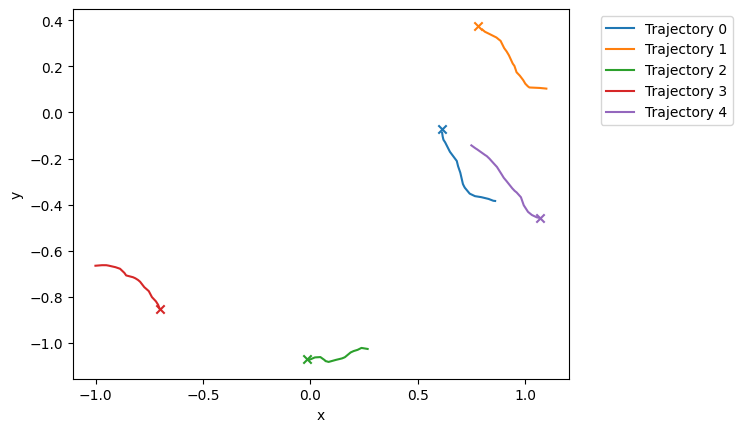

In [10]:
plot_n_trajectories = 5
fig, ax = plt.subplots()
for i in range(plot_n_trajectories):
    init_x = traj["init_x"][i]
    init_y = traj["init_y"][i]
    ax.plot(x[i, :], y[i, :], label=f"Trajectory {i}")
    ax.scatter(init_x, init_y, color=f"C{i}", marker="x")
ax.set_xlabel("x")
ax.set_ylabel("y")
# Putting the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plotting simulated place cell ratemaps and time-series

In [11]:
pc_inputs, position, pc_outputs = generator.get_test_batch()

In [12]:
position.shape, pc_outputs.shape

(torch.Size([20, 256, 2]), torch.Size([20, 256, 512]))

In [13]:
pc_outputs_np = pc_outputs.reshape(-1, n_place_cells).detach().cpu()
pc = place_cells.grid_pc(pc_outputs_np[::100], res=100)

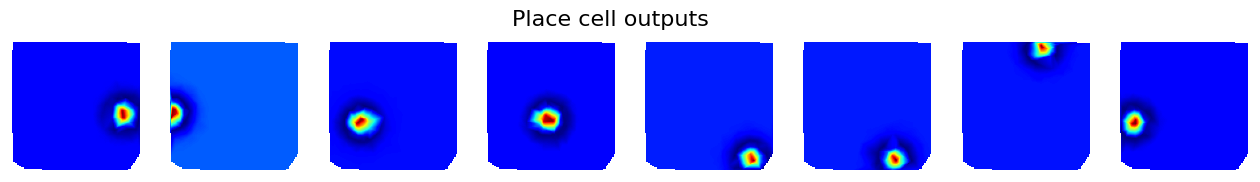

In [15]:
plt.figure(figsize=(16,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(pc[i], cmap='jet')
    plt.axis('off')
        
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

In [17]:
pc_outputs[::100].shape

torch.Size([1, 256, 512])

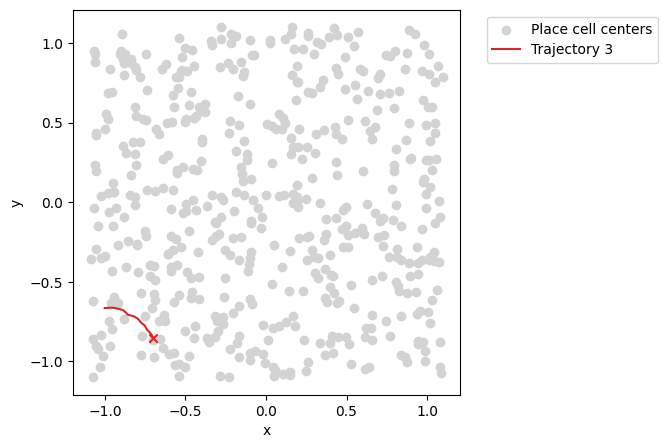

In [15]:
trajectory_id = 3
us = place_cells.cell_positions.cpu()
f, ax = plt.subplots(figsize=(5,5))
ax.scatter(us[:,0], us[:,1], c='lightgrey', label='Place cell centers')
init_x = traj["init_x"][trajectory_id]
init_y = traj["init_y"][trajectory_id]
ax.plot(x[trajectory_id, :], y[trajectory_id, :], label=f"Trajectory {trajectory_id}", color=f"C{trajectory_id}")
ax.scatter(init_x, init_y, color=f"C{trajectory_id}", marker="x")
ax.set_xlabel("x")
ax.set_ylabel("y")
# Placing legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [16]:
pc_rates_trajectory = pc_outputs[:, trajectory_id, :].detach().cpu().numpy()

In [17]:
pc_rates_trajectory.shape

(20, 512)

Text(0, 0.5, 'Firing rate')

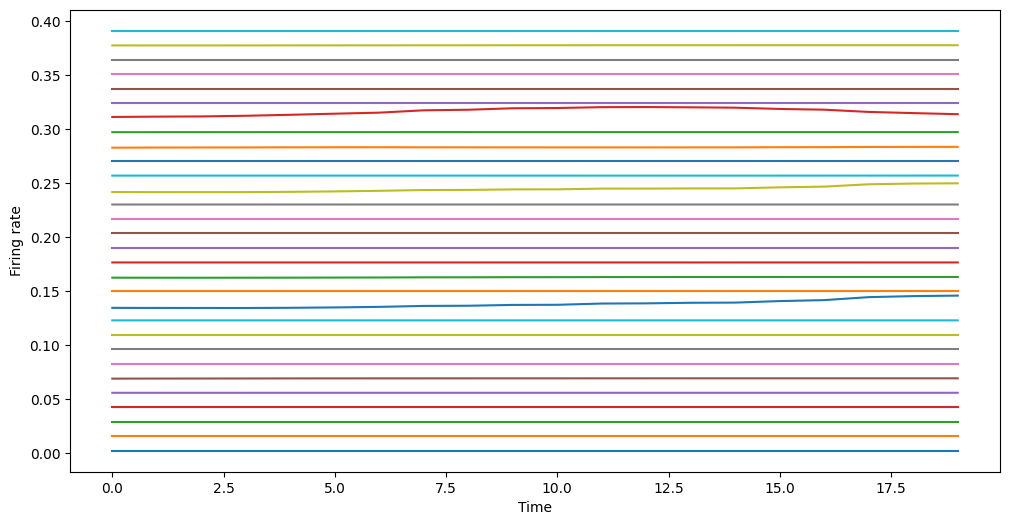

In [18]:
f, ax = plt.subplots(figsize=(12, 6))
plot_n_place_cells = 30
max_rate = np.amax(pc_rates_trajectory)

for i in range(plot_n_place_cells):
    ax.plot(pc_rates_trajectory[:, i]+i*max_rate, label=f"Place cell {i}")
ax.set_xlabel("Time")
ax.set_ylabel("Firing rate")

# Training a RNN

In [19]:
loss_list, err_list = [], []
optimizer = torch.optim.RMSprop(rnn.parameters(), lr=learning_rate)

In [20]:
gen = generator.get_generator()

for step_idx in tqdm(range(training_steps)):
    inputs, pc_outputs, pos = next(gen)
    rnn.zero_grad()
    loss, err = rnn.compute_loss(inputs, pc_outputs, pos)
    loss.backward()
    optimizer.step()
    loss_np = loss.detach().cpu().numpy()
    err_np = err.detach().cpu().numpy()
    loss_list.append(loss_np)
    err_list.append(err_np)

100%|██████████| 100000/100000 [21:05<00:00, 79.00it/s]


In [21]:
print("last error", err_list[-1])

last error 0.0469342845086544


In [22]:
# TODO: Need to move trained models to neuralplayground online storage
model_save_path = "tmp_tutorial_model"
model_name = "based_rnn"
torch.save(rnn.state_dict(), os.path.join(model_save_path, model_name))
pickle.dump((loss_list, err_list), open(os.path.join(model_save_path, model_name+"loss_err.pkl"), "wb"), protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# Start here if you don't want to train again
model_save_path = "tmp_tutorial_model"
model_name = "based_rnn"
rnn = RNN(Ng=n_grid_cells,
          Np=n_place_cells,
          sequence_length=sequence_length,
          weight_decay=weight_decay,
          place_cells=place_cells,
          activation=activation)
rnn.load_state_dict(torch.load(os.path.join(model_save_path, model_name)))
rnn.to(device)
loss_list, err_list = pickle.load(open(os.path.join(model_save_path, model_name+"loss_err.pkl"), "rb"))

Text(0.5, 0, 'train step')

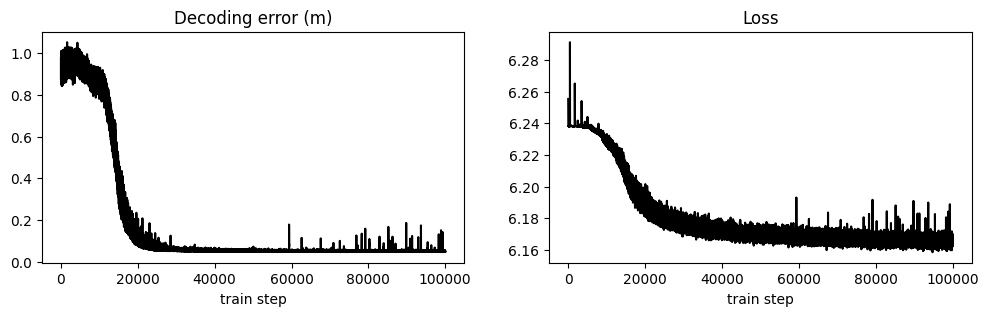

In [24]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(err_list, c='black')

plt.title('Decoding error (m)'); plt.xlabel('train step')
plt.subplot(122)
plt.plot(loss_list, c='black')
plt.title('Loss'); plt.xlabel('train step')

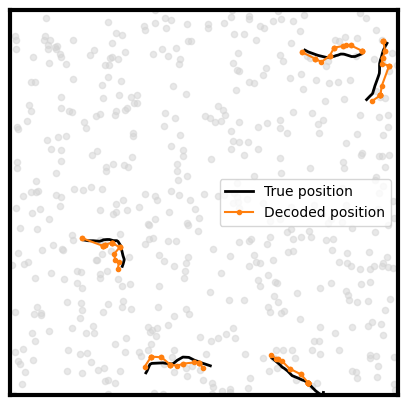

In [25]:
inputs, pos, pc_outputs = generator.get_test_batch()
pos = pos.cpu()
pred_pos = place_cells.get_nearest_cell_pos(rnn.predict(inputs)).cpu()
us = place_cells.cell_positions.cpu()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(5):
    plt.plot(pos[:,i,0], pos[:,i,1], c='black', label='True position', linewidth=2)
    plt.plot(pred_pos[:,i,0], pred_pos[:,i,1], '.-',
             c='C1', label='Decoded position')
    if i==0:
        plt.legend()
plt.scatter(us[:,0], us[:,1], s=20, alpha=0.5, c='lightgrey')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.xticks([])
plt.yticks([])
plt.xlim([-room_depth/2,room_width/2])
plt.ylim([-room_depth/2,room_depth/2]);

In [26]:
pred_pos.shape, pos.shape

(torch.Size([20, 256, 2]), torch.Size([20, 256, 2]))

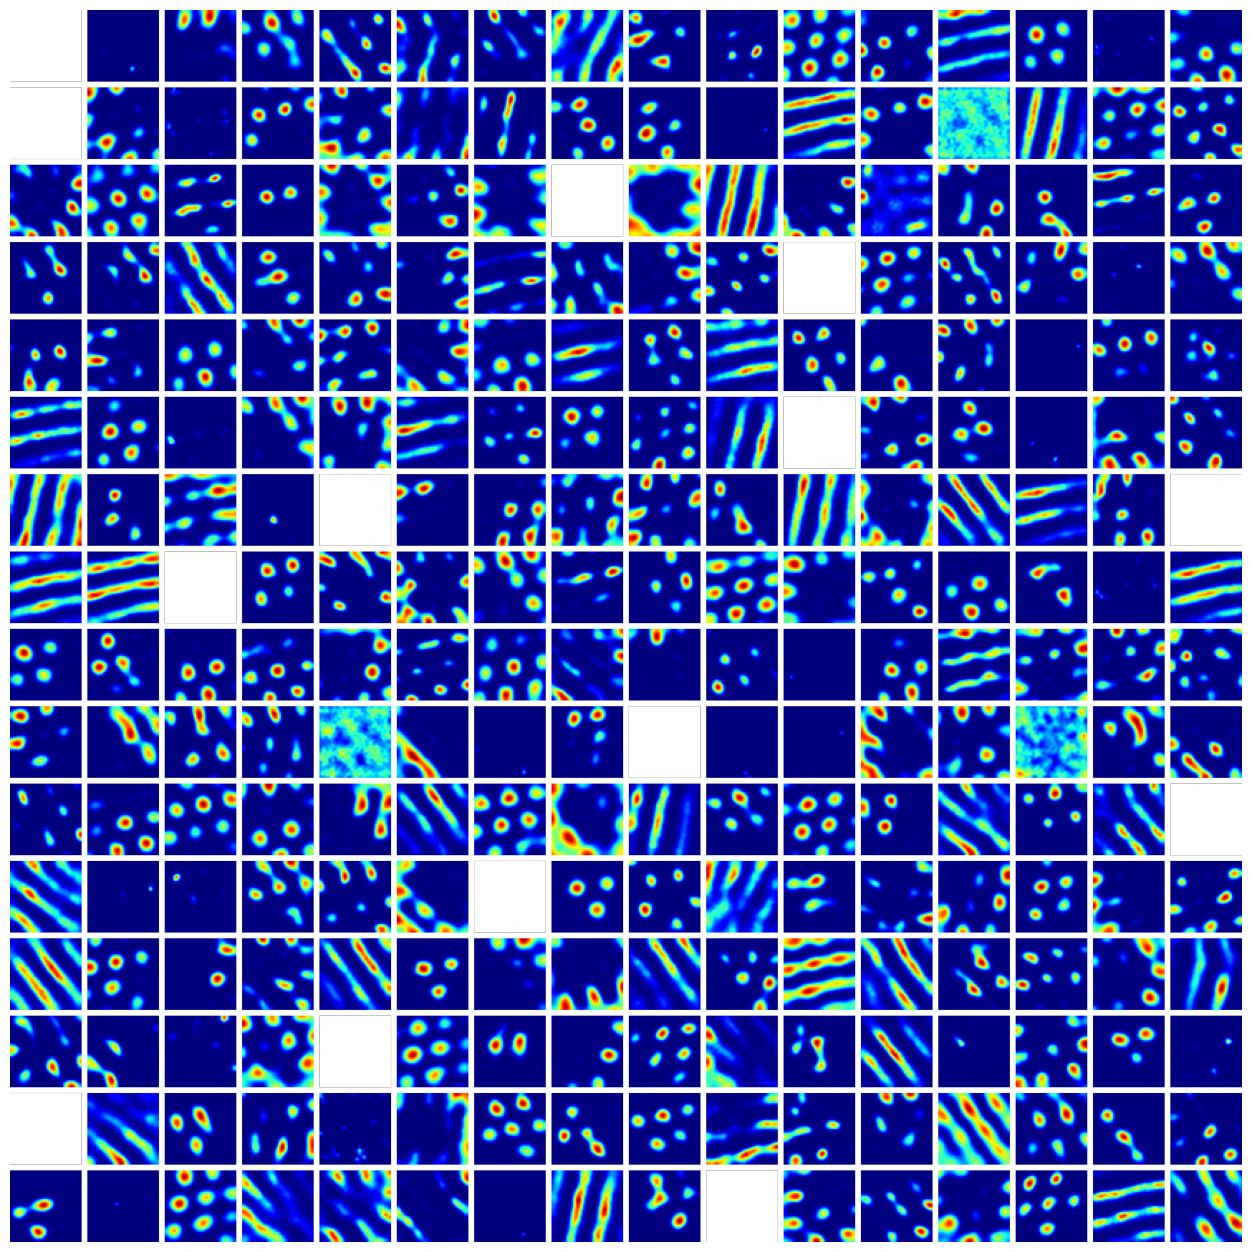

In [33]:
from neuralplayground.vendored import plot_ratemaps, compute_ratemaps
res = 50
n_avg = 100
Ng = n_grid_cells
activations, rate_map, g, pos = compute_ratemaps(rnn,
                                                generator,
                                                sequence_length,
                                                batch_size,
                                                room_width,
                                                room_depth,
                                                res=res,
                                                n_avg=n_avg,
                                                Ng=Ng)

# Compute a set of lo-res maps to use for evalutaing grid score
lo_res = 20
_, rate_map_lores, _, _ = compute_ratemaps(rnn,
                                                generator,
                                                sequence_length,
                                                batch_size,
                                                room_width,
                                                room_depth,
                                                res=res,
                                                n_avg=n_avg,
                                                Ng=Ng)
n_plot = 256
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off');

## 3D torus plot

In [28]:
# Fourier transform 
Ng = n_grid_cells
rm_fft_real = np.zeros([Ng,res,res])
rm_fft_imag = np.zeros([Ng,res,res])

for i in tqdm(range(Ng)):
    rm_fft_real[i] = np.real(np.fft.fft2(rate_map[i].reshape([res,res])))
    rm_fft_imag[i] = np.imag(np.fft.fft2(rate_map[i].reshape([res,res])))
    
rm_fft = rm_fft_real + 1j * rm_fft_imag

100%|██████████| 512/512 [00:00<00:00, 10738.55it/s]


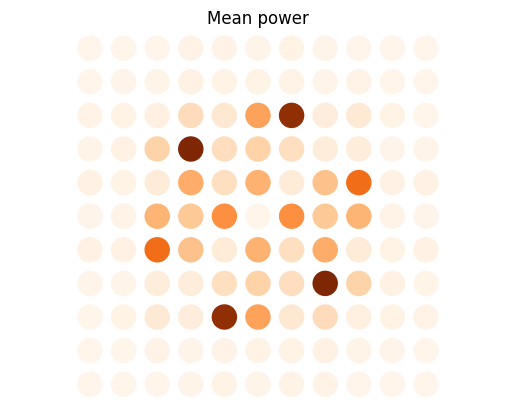

In [29]:
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
im = (np.real(rm_fft)**2).mean(0)
im[0,0] = 0
plt.scatter(x2,y2,c=im[idxs][:,idxs], s=300, cmap='Oranges')
plt.axis('equal')
plt.axis('off');
plt.title('Mean power');

In [30]:
k1 = [3,0]
k2 = [2,3]
k3 = [-1,3]
k4=k5=k6=k1

freq = 1
ks = freq*np.array([k1,k2,k3,k4,k5,k6])
ks = ks.astype('int')

modes = np.stack([rm_fft[:,k[0],k[1]] for k in ks])

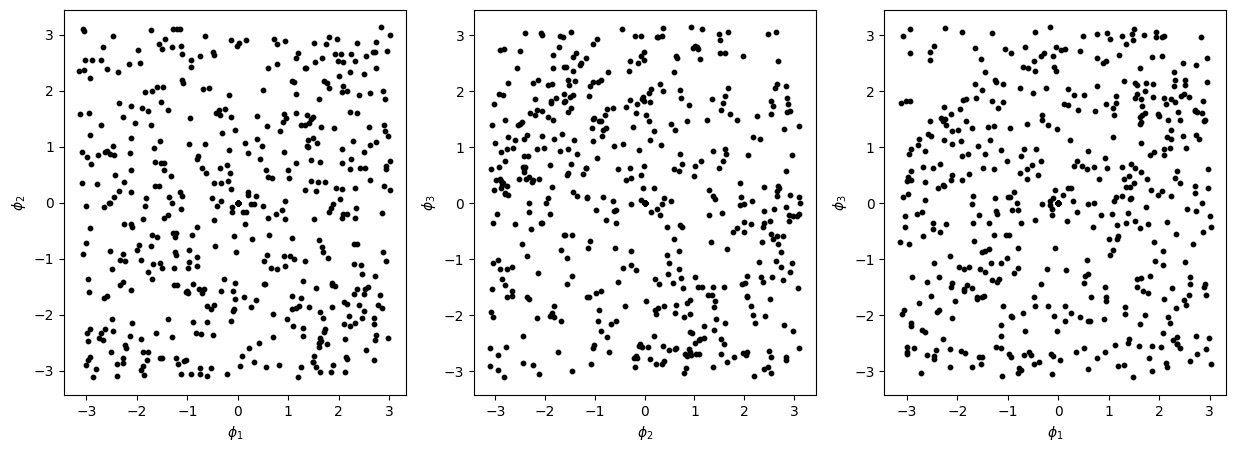

In [31]:
# Find phases
phases = [np.angle(mode) for mode in modes]

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(phases[0], phases[1], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.subplot(132)
plt.scatter(phases[1], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_2$')
plt.ylabel(r'$\phi_3$')
plt.subplot(133)
plt.scatter(phases[0], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_3$')
plt.show()

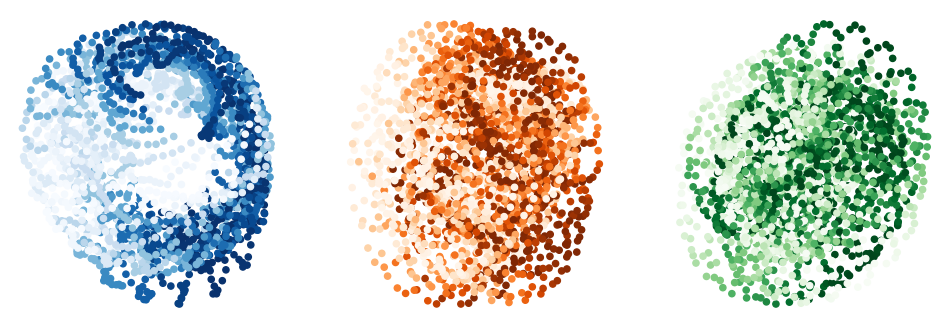

In [32]:
from mpl_toolkits.mplot3d import Axes3D

freq = 1
crop = 0
cmaps = ['Blues', 'Oranges', 'Greens']
x = np.mgrid[:res,:res] * 2*np.pi/ res
x = x.reshape(2, -1)
k = freq*np.stack([k1,k2,k3])
X = np.concatenate([np.cos(k.dot(x)), np.sin(k.dot(x))], axis=0)
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    B = np.stack([np.cos(phases[i]), np.sin(phases[i])])
    test = B@rate_map
    plt.scatter(test[0], test[1], c=X[i][idxs], cmap=cmaps[i], s=20)
    plt.axis('off')